In [2]:
import os   # for path operations
import datetime

import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10633599420377407523
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9215183422
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8919487233637679052
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
patience=40
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="weights.hdf5", save_best_only=True, verbose =1)

In [5]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [6]:
def make_timeseries_instances(timeseries,window_size,nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
    for coord in range(3):
        np.roll(X[:,coord+9],1) #move coordinates to the past
    
    # We have 3 output signal: x, y and z position    
    y = timeseries[window_size:,-11:-8]
    return X,y

In [7]:
def evalute_timeseries(timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    #timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 8 #only 12 inputs (previous x,y,z position is an input now)
    #nb_outputs = nb_series - 12 #only 9 outputs
    nb_outputs=3
  
    #initialize model
    model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    #fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Standardize input variables for train, valid and test data
    for inpt in range(X.shape[1]):
        scaler = preprocessing.StandardScaler().fit(X_train[:,inpt])
        X_train[:,inpt] = scaler.transform(X_train[:,inpt])
        X_valid[:,inpt] = scaler.transform(X_valid[:,inpt])
        X_test[:,inpt] = scaler.transform(X_test[:,inpt])
    
    #train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    #load the best model for plotting
    bestmodel = load_model("weights.hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    print(preds.shape)
    print(targets.shape)
    
    # Plot predicted x vs target x
    plt.figure(0)
    plt.plot(preds[:,0],color='green')
    plt.plot(targets[:,0],color='red')
    
    # Plot predicted z vs target z
    plt.figure(1)
    plt.plot(preds[:,2],color='blue')
    plt.plot(targets[:,2],color='yellow')
    
    # Plot the predicted route vs original route on x-z plane
    plt.figure(2)
    plt.plot(preds[:,0],preds[:,2])
    plt.plot(targets[:,0],targets[:,2])

In [15]:
DataFiltered = pd.read_csv('Bazs\\PreprocessedData.txt',
                               sep='\t',
                               decimal=',')

In [16]:
DataFiltered.head(2)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,orient,deltat,level
0,94557.9688,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.02,0.0,1.0,0.0,0.0,0.0
1,94557.9787,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.02,0.001,1.0,-2.312,0.0099,0.0


In [10]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 500
batch_size = 16
validation_split = 0.2

In [18]:
print(DataFiltered.shape)
timeData=np.array(DataFiltered, dtype='float64')
# Delete timestamps, we dont need absolute time as an input
timeData=np.delete(timeData,0,1)
print(timeData.shape)

(7678, 21)
(7678, 20)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 16, 4)             244       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________
Train on 382


Epoch 00041: val_loss did not improve from 0.00970
Epoch 42/500
 - 1s - loss: 5.5066e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0088 - val_mean_absolute_error: 0.0641

Epoch 00042: val_loss improved from 0.00970 to 0.00877, saving model to weights.hdf5
Epoch 43/500
 - 1s - loss: 5.4678e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0104 - val_mean_absolute_error: 0.0674

Epoch 00043: val_loss did not improve from 0.00877
Epoch 44/500
 - 1s - loss: 5.1145e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0117 - val_mean_absolute_error: 0.0711

Epoch 00044: val_loss did not improve from 0.00877
Epoch 45/500
 - 1s - loss: 5.1155e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0100 - val_mean_absolute_error: 0.0663

Epoch 00045: val_loss did not improve from 0.00877
Epoch 46/500
 - 1s - loss: 4.8146e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0118 - val_mean_absolute_error: 0.0709

Epoch 00046: val_loss did not improve from 0.00877
Epoch 47/500
 - 1s - loss: 4.6156e-04 - mean_abso


Epoch 00088: val_loss did not improve from 0.00743
Epoch 89/500
 - 1s - loss: 3.2760e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0091 - val_mean_absolute_error: 0.0647

Epoch 00089: val_loss did not improve from 0.00743
Epoch 90/500
 - 1s - loss: 3.1484e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0091 - val_mean_absolute_error: 0.0639

Epoch 00090: val_loss did not improve from 0.00743
Epoch 91/500
 - 1s - loss: 3.0777e-04 - mean_absolute_error: 0.0112 - val_loss: 0.0094 - val_mean_absolute_error: 0.0657

Epoch 00091: val_loss did not improve from 0.00743
Epoch 92/500
 - 1s - loss: 3.2037e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0083 - val_mean_absolute_error: 0.0603

Epoch 00092: val_loss did not improve from 0.00743
Epoch 93/500
 - 1s - loss: 3.1965e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0084 - val_mean_absolute_error: 0.0607

Epoch 00093: val_loss did not improve from 0.00743
Epoch 94/500
 - 1s - loss: 2.8780e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0

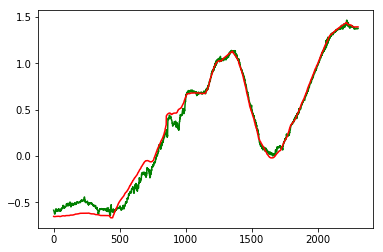

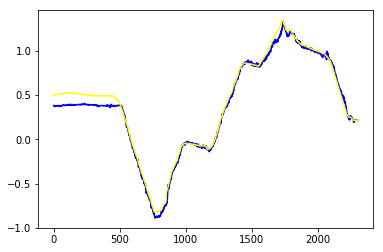

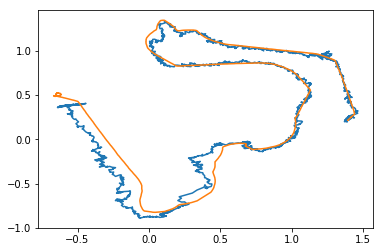

In [19]:
evalute_timeseries(timeData,window_size,filter_length,nb_filter, epochs, batch_size)

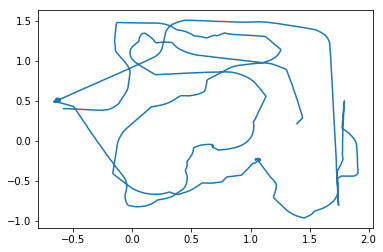

In [20]:
plt.plot(timeData[:,-11],timeData[:,-9])